# Experiment 
We'll experiment with Diabetes dataset for Linear Regression learning

In [2]:
from sklearn.datasets import load_diabetes 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

## Feature EDA and Analysis 

In [3]:
diabetes = load_diabetes() 
X = diabetes.data 
y = diabetes.target 

In [4]:
X.shape, y.shape

((442, 10), (442,))

In [5]:
pd.DataFrame(X, columns=diabetes.feature_names)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


### Helper Functions

In [6]:
class LinearRegressionModel:
    def __init__(self):
        self.model = LinearRegression()
        self.eval_score = None 

    def split_data(self, X, y, random_state=0):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
        return X_train, X_test, y_train, y_test

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train) 

    def eval(self, X_test, y_test, doPrint=False):
        self.eval_score = self.model.score(X_test, y_test)
        if doPrint:
            print(f"Model R^2 Score: {self.model.score(X_test, y_test)}")

    def predict(self, X):
        return self.model.predict(X)
        

### Linear Regression Assumption Validation Check 
1. Linear relationship: The relationship between the independent variable(s) and the dependent variable is linear. 
2. Normally distributed errors: The errors, or residuals, are normally distributed, with a mean of zero and equal variances. 
3. Homoscedasticity: The variability of the residuals is consistent across all levels of the independent variables. 
4. Independence of errors: The errors of the response variables are not correlated. 
5. No multicollinearity: The independent variables are not too highly correlated with each other. 


#### Check assumption number 5, multicollinearity + test of independence of each IV
Plot correlation matrix as a heatmap. Turns out S1, and S2 are highly correlated.

Decision:  
- We can remove S1 or S2 (if S1 or S2 is not significantly important in predicting target)
- OR we can create a new variable S12 combining (averaging S1 and S2 if both of them are equally important)

<Axes: >

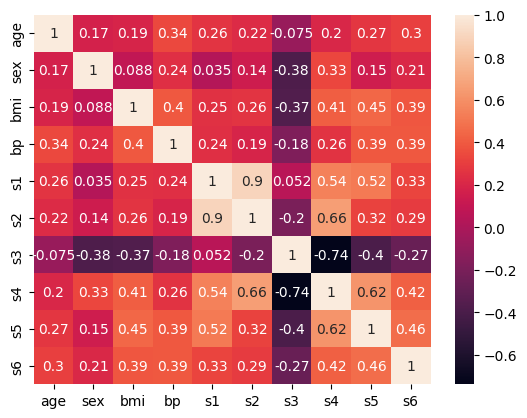

In [7]:
import seaborn as sns
sns.heatmap(pd.DataFrame(X, columns=diabetes.feature_names).corr(), annot=True)

#### Check assumption number 1: Linearity of Xs and Target

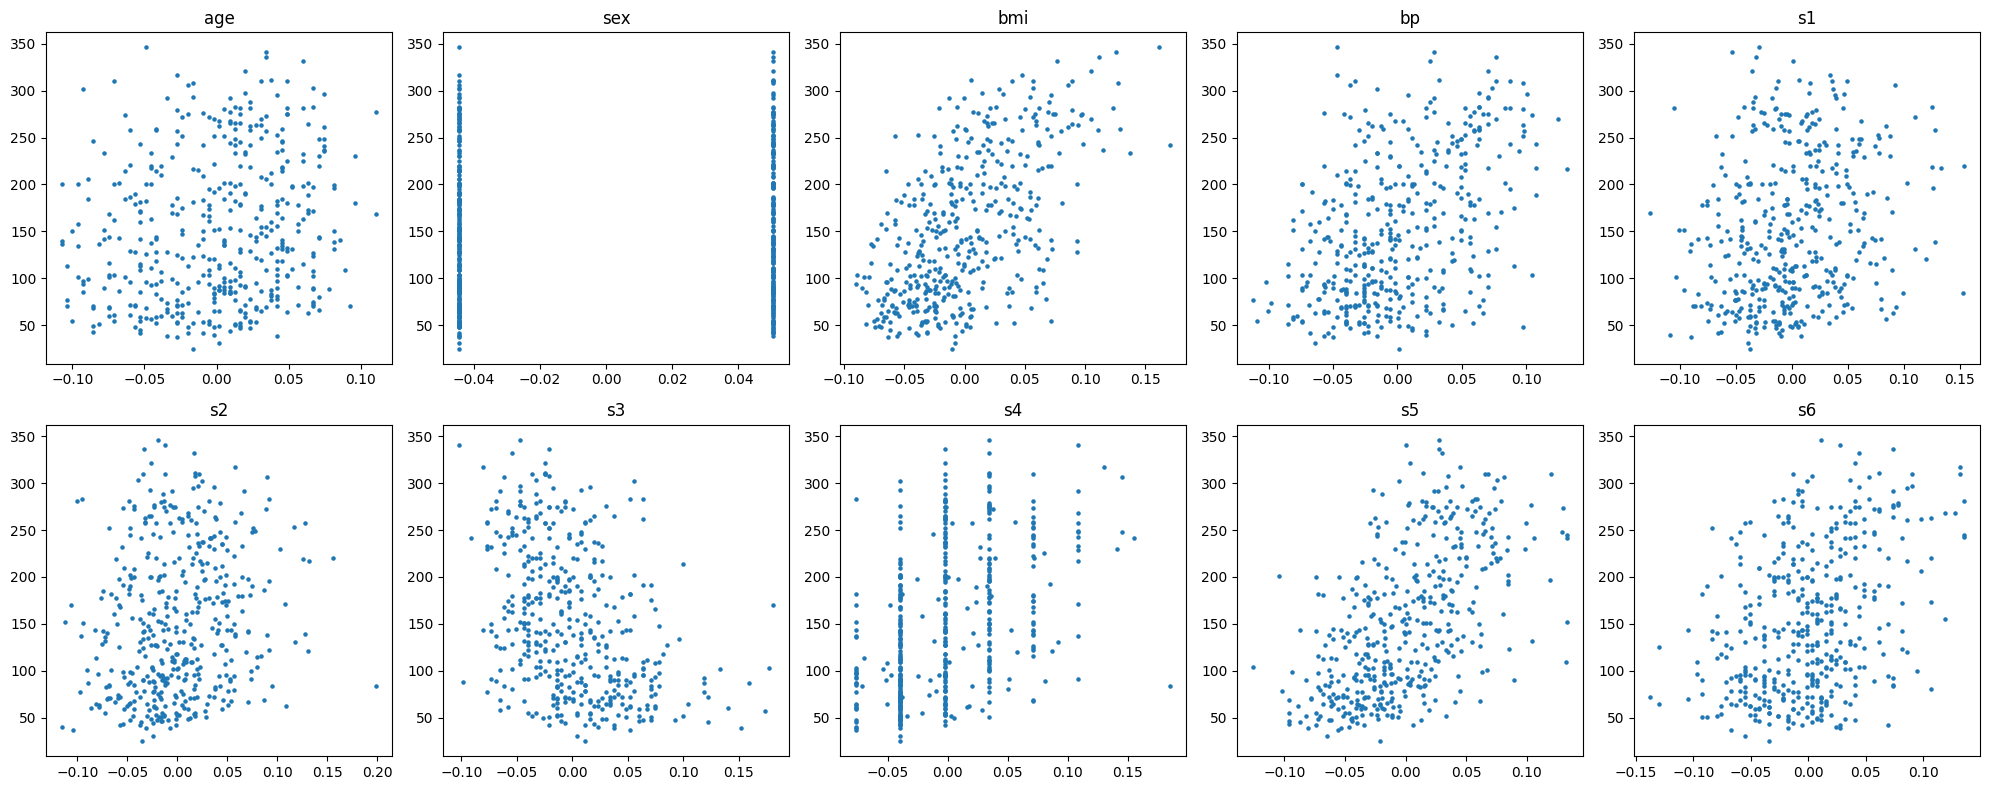

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8)) 
for i in range(10):
    axes[i//5, i%5].scatter(X[:, i], y, s=5)
    axes[i//5, i%5].set_title(diabetes.feature_names[i])
plt.tight_layout()
plt.show()

Note: Binary feature "Sex" is not too heavily skewed towards one value, so still has some predicting power. More to reveal after importance analysis. 

<Axes: ylabel='Density'>

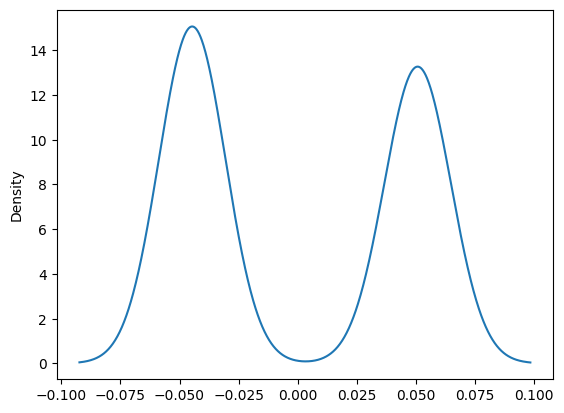

In [9]:
pd.Series(X[:,1]).plot.density()

Distribution of Feature 7

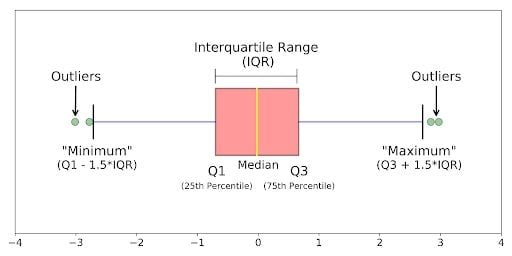

<Axes: >

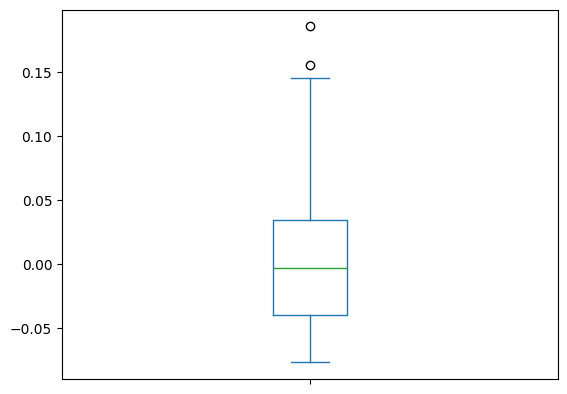

In [10]:
pd.Series(X[:,7]).plot.box()

#### Check assumption number 2: Normally distributed errors

In [11]:
max_base_score = 0 
max_random = 0 
for i in range(30):
    baseline_model = LinearRegressionModel()
    X_train, X_test, y_train, y_test = baseline_model.split_data(X, y, random_state=i) 
    baseline_model.train(X_train, y_train)
    baseline_model.eval(X_test, y_test)
    if baseline_model.eval_score > max_base_score:
        max_base_score = baseline_model.eval_score 
        max_random = i
print(f"Max R^2 Score: {max_base_score} at random state {max_random}")
baseline_model = LinearRegressionModel()
X_train, X_test, y_train, y_test = baseline_model.split_data(X, y, random_state=max_random)
baseline_model.train(X_train, y_train)
baseline_model.eval(X_test, y_test)
print(f"Model R^2 Score: {baseline_model.eval_score}")

Max R^2 Score: 0.585114043418069 at random state 9
Model R^2 Score: 0.585114043418069


<Axes: >

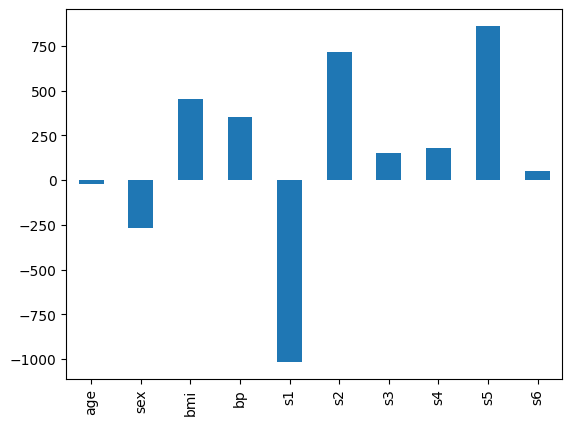

In [12]:
pd.Series(baseline_model.model.coef_, index=diabetes.feature_names).plot.bar()

Q-Q plot doesn't align, residuals are not normally distributed. Violating Assumption 2. Data is likely left-skewed. 

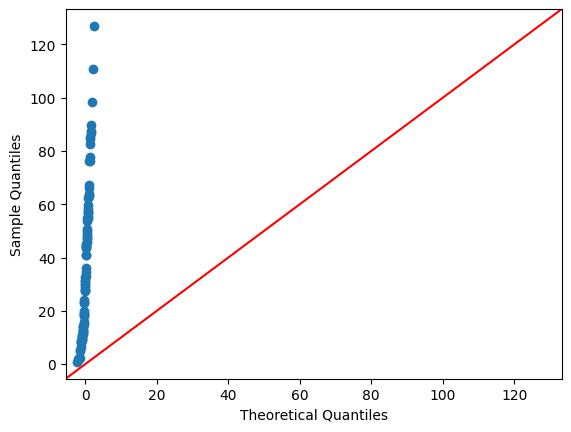

In [13]:
#model predictions
y_pred = baseline_model.predict(X_test)
residuals = np.abs(y_test - y_pred)

#draw a Q-Q plot of the residuals 
import statsmodels.api as sm 
sm.qqplot(residuals, line ='45')
plt.show()

## To Do based on Assumption Violations
1. Transform DV using box-cox transformation
2. Check outliers 
3. Bootstrapped estimates 
4. Remove S1 or S2

Remove each feature and check results

In [14]:
# Let's try by removing each feature and see of the model improves 

for i in range(10):
    X_no_s1 = np.delete(X.copy(), i, axis=1)
    X_train, X_test, y_train, y_test = baseline_model.split_data(X_no_s1, y, random_state=max_random) 
    baseline_model.train(X_train, y_train)
    baseline_model.eval(X_test, y_test, doPrint=False)
    print(f"Removed {diabetes.feature_names[i]}, score: {baseline_model.eval_score}")

X_train, X_test, y_train, y_test = baseline_model.split_data(X.copy(), y, random_state=max_random)
baseline_model.train(X_train, y_train)
baseline_model.eval(X_test, y_test, doPrint=True) 

Removed age, score: 0.5857582142302339
Removed sex, score: 0.5874282717126666
Removed bmi, score: 0.446885180439032
Removed bp, score: 0.578835589446083
Removed s1, score: 0.5962947307530875
Removed s2, score: 0.5994677362209271
Removed s3, score: 0.5872077489343309
Removed s4, score: 0.584028184149238
Removed s5, score: 0.6001180439541403
Removed s6, score: 0.5808060406238239
Model R^2 Score: 0.585114043418069


CV=5

In [15]:
from sklearn.model_selection import cross_val_score
cv_model = LinearRegressionModel()
cv_scores = cross_val_score(cv_model.model, X, y, cv=5) 
print(f"Cross Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores)}, STD: {np.std(cv_scores)}")


Cross Validation Scores: [0.42955615 0.52259939 0.48268054 0.42649776 0.55024834]
Mean CV Score: 0.48231643590864215, STD: 0.049268577511903826


Box-Cox Transformation 

In [16]:
from scipy.stats import boxcox 

boxcox_model = LinearRegressionModel()
y_boxcox, lamda = boxcox(y)
X_train, X_test, y_train, y_test = boxcox_model.split_data(X, y_boxcox, random_state=max_random)
boxcox_model.train(X_train, y_train)
boxcox_model.eval(X_test, y_test, doPrint=True)

Model R^2 Score: 0.5615601551142285


BoxCox + CV=5

In [17]:
boxcox_cv_model = LinearRegressionModel()
y_boxcox, lamda = boxcox(y)
cv_scores = cross_val_score(boxcox_cv_model.model, X, y_boxcox, cv=5)
print(f"Cross Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores)}, STD: {np.std(cv_scores)}")

Cross Validation Scores: [0.40857401 0.49765637 0.4532066  0.43509954 0.54610079]
Mean CV Score: 0.46812746465628835, STD: 0.04860429197400979


BoxCox + No S1 + CV = 5

In [20]:
boxcox_nos1_cv_model = LinearRegressionModel()
y_boxcox, lamda = boxcox(y)
X_no_s1 = np.delete(X.copy(), 4, axis=1)
cv_scores = cross_val_score(boxcox_nos1_cv_model.model, X_no_s1, y_boxcox, cv=5)
print(f"Cross Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores)}, STD: {np.std(cv_scores)}")

Cross Validation Scores: [0.39585507 0.49305565 0.46082387 0.42688058 0.53587046]
Mean CV Score: 0.46249712281794475, STD: 0.049050934724636855


BoxCox + No Age + No S6 + CV=5

Cross Validation Scores: [0.40587992 0.50236543 0.4608608  0.46144294 0.53772966]
Mean CV Score: 0.47365574901267904, STD: 0.04435343904984904
Model R^2 Score: 0.4950726424733134


<Axes: >

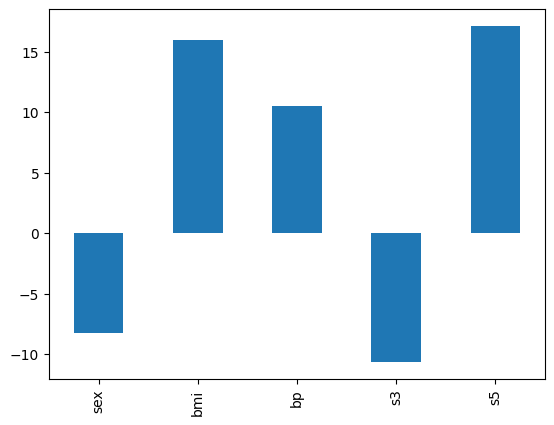

In [31]:
boxcox_no_vars_cv_model = LinearRegressionModel()
y_boxcox, lamda = boxcox(y)
X_no_vars = np.delete(X.copy(), [0, 4, 5, 7, 9], axis=1)
cv_scores = cross_val_score(boxcox_no_vars_cv_model.model, X_no_vars, y_boxcox, cv=5)
print(f"Cross Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores)}, STD: {np.std(cv_scores)}")

# Fit the model
boxcox_no_vars_cv_model.model.fit(X_no_vars, y_boxcox)
boxcox_no_vars_cv_model.eval(X_no_vars, y_boxcox, doPrint=True)

# Plot coefficients
pd.Series(boxcox_no_vars_cv_model.model.coef_, index=np.delete(diabetes.feature_names, [0, 4, 5, 7, 9])).plot.bar()

Remember: If you're just using CV to evaluate a single model's performance, you don't need the initial split. If you're using CV results to make modeling decisions or tune parameters, use a train-test split first to avoid data leakage.

# Linear Regression with Standard Pipeline

In [32]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}

# Perform cross-validation
cv_results = cross_validate(
    pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1  # Use all available cores
)

# Process and display results
print("\nCross-Validation Results:")
print("-" * 50)

# Function to process scores
def process_scores(metric_name, train_scores, test_scores):
    if metric_name == 'mse' or metric_name == 'mae':
        train_scores = -train_scores  # Convert back to positive values
        test_scores = -test_scores
    
    print(f"\n{metric_name.upper()} Scores:")
    print(f"Train - Mean: {train_scores.mean():.4f} (+/- {train_scores.std() * 2:.4f})")
    print(f"Test  - Mean: {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")
    print(f"Individual fold scores: {test_scores}")

# Process each metric
for metric in scoring.keys():
    process_scores(
        metric,
        cv_results[f'train_{metric}'],
        cv_results[f'test_{metric}']
    )

# Print average fit times
print(f"\nAverage fit time: {cv_results['fit_time'].mean():.3f} seconds")
print(f"Average score time: {cv_results['score_time'].mean():.3f} seconds")


Cross-Validation Results:
--------------------------------------------------

R2 Scores:
Train - Mean: 0.5198 (+/- 0.0404)
Test  - Mean: 0.4785 (+/- 0.1699)
Individual fold scores: [0.45260276 0.57320015 0.39144785 0.58428888 0.39081186]

MSE Scores:
Train - Mean: 2842.9878 (+/- 140.1552)
Test  - Mean: 3015.3817 (+/- 582.4796)
Individual fold scores: [2900.19362849 2662.63760862 3312.30588884 2797.88355256 3403.88779293]

MAE Scores:
Train - Mean: 43.2119 (+/- 1.0449)
Test  - Mean: 44.2697 (+/- 5.2154)
Individual fold scores: [42.79409468 41.58260275 47.22331116 42.12235506 47.62636803]

Average fit time: 0.001 seconds
Average score time: 0.001 seconds
